# Density Matrix Renormalization Group

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
L = 60
limit = 4
h = 1
J = h/2
s_x = h/2*np.array([[0,1],
                [1,0]])
s_y = h/2*np.array([[0,-1j],
               [1j,0]])
s_z = h/2*np.array([[1,0],
                [0,-1]])

## Define Operators (First Half for Left and Second Half for Right)

In [3]:
s_x_operators = [None] * L
s_y_operators = [None] * L
s_z_operators = [None] * L
s_x_s_x_operators = [None] * (L//2)
s_z_s_z_operators = [None] * (L//2)

## Init Operators

In [4]:
for site_index in range(L):
    if site_index == 0:
        s_x_operators[site_index] = s_x
        s_y_operators[site_index] = s_y
        s_z_operators[site_index] = s_z
        s_x_s_x_operators[site_index] = np.dot(s_x,s_x)
        s_z_s_z_operators[site_index] = np.dot(s_z,s_z)
    elif site_index == L-1:
        s_x_operators[site_index] = s_x
        s_y_operators[site_index] = s_y
        s_z_operators[site_index] = s_z
    else:
        s_x_operators[site_index] = np.eye(2)
        s_y_operators[site_index] = np.eye(2)
        s_z_operators[site_index] = np.eye(2)
        if site_index < (L//2):
            s_x_s_x_operators[site_index] = s_x
            s_z_s_z_operators[site_index] = s_z

## Adding Site

In [5]:
H_L = np.zeros((2,2),dtype=np.complex128)
H_R = np.zeros((2,2),dtype=np.complex128)
for adding_site_index in range(1,L//2):
    
    # update Hamiltonian
    H_L = np.kron(H_L,np.eye(2))
    H_L += J*np.kron(s_x_operators[adding_site_index-1],s_x)
    H_L += J*np.kron(s_y_operators[adding_site_index-1],s_y)
    H_L += J*np.kron(s_z_operators[adding_site_index-1],s_z)
    H_R = np.kron(np.eye(2),H_R)
    H_R += J*np.kron(s_x,s_x_operators[-adding_site_index])
    H_R += J*np.kron(s_y,s_y_operators[-adding_site_index])
    H_R += J*np.kron(s_z,s_z_operators[-adding_site_index])
    
    # update Sx,Sy,Sz
    for i in range(L//2):
        if (i == adding_site_index):
            s_x_operators[i] = np.kron(s_x_operators[i],s_x)
            s_y_operators[i] = np.kron(s_y_operators[i],s_y)
            s_z_operators[i] = np.kron(s_z_operators[i],s_z)
            s_x_s_x_operators[i] = np.kron(s_x_s_x_operators[i],s_x)
            s_z_s_z_operators[i] = np.kron(s_z_s_z_operators[i],s_z)
        else:
            s_x_operators[i] = np.kron(s_x_operators[i],np.eye(2))
            s_y_operators[i] = np.kron(s_y_operators[i],np.eye(2))
            s_z_operators[i] = np.kron(s_z_operators[i],np.eye(2))
            s_x_s_x_operators[i] = np.kron(s_x_s_x_operators[i],np.eye(2))
            s_z_s_z_operators[i] = np.kron(s_z_s_z_operators[i],np.eye(2))
    for j in range(L//2,L):
        if (j == L-adding_site_index-1):
            s_x_operators[j] = np.kron(s_x,s_x_operators[j])
            s_y_operators[j] = np.kron(s_y,s_y_operators[j])
            s_z_operators[j] = np.kron(s_z,s_z_operators[j])
        else:
            s_x_operators[j] = np.kron(np.eye(2),s_x_operators[j])
            s_y_operators[j] = np.kron(np.eye(2),s_y_operators[j])
            s_z_operators[j] = np.kron(np.eye(2),s_z_operators[j])
            
    # Truncation
    if (adding_site_index >= limit) :
        #print('ops')
        D_R = 5 #adding_site_index + 1
        D_L = 5 #adding_site_index + 1
        H = np.kron(H_L,np.eye(2**D_R)) + np.kron(np.eye(2**D_L),H_R)
        H += J*np.dot(np.kron(s_x_operators[adding_site_index],np.eye(2**D_R)),np.kron(np.eye(2**D_L),s_x_operators[L-adding_site_index-1]))
        H += J*np.dot(np.kron(s_y_operators[adding_site_index],np.eye(2**D_R)),np.kron(np.eye(2**D_L),s_y_operators[L-adding_site_index-1]))
        H += J*np.dot(np.kron(s_z_operators[adding_site_index],np.eye(2**D_R)),np.kron(np.eye(2**D_L),s_z_operators[L-adding_site_index-1]))
        
        eigenvalues, eigenvectors = np.linalg.eigh(H)
        ground_state = eigenvectors[:,0]
        ground_state_tiled = np.reshape(ground_state, (2**D_R,2**D_L))
        rho_L = ground_state_tiled @ ground_state_tiled.conj().T
        rho_R = ground_state_tiled.T @ ground_state_tiled.conj()
        
        L_eigenvalues, L_eigenvectors = np.linalg.eigh(rho_L)
        R_eigenvalues, R_eigenvectors = np.linalg.eigh(rho_R)
        
        T_L = L_eigenvectors[:,(-2**limit):]
        U_L = T_L[:, ::-1]
        
        T_R = R_eigenvectors[:,(-2**limit):]
        U_R = T_R[:, ::-1]
        
        H_L = U_L.conj().T @ H_L @ U_L
        H_R = U_R.conj().T @ H_R @ U_R
        
        for k in range(L//2):
            s_x_operators[k] = U_L.conj().T @ s_x_operators[k] @ U_L
            s_y_operators[k] = U_L.conj().T @ s_y_operators[k] @ U_L
            s_z_operators[k] = U_L.conj().T @ s_z_operators[k] @ U_L
            s_x_s_x_operators[k] = U_L.conj().T @ s_x_s_x_operators[k] @ U_L
            s_z_s_z_operators[k] = U_L.conj().T @ s_z_s_z_operators[k] @ U_L
        for m in range(L//2,L):
            s_x_operators[m] = U_R.conj().T @ s_x_operators[m] @ U_R
            s_y_operators[m] = U_R.conj().T @ s_y_operators[m] @ U_R
            s_z_operators[m] = U_R.conj().T @ s_z_operators[m] @ U_R
            
        

## Calculate Energy and Correlations

In [6]:
H_final = np.kron(H_L,np.eye(2**6))+np.kron(np.eye(2**6),H_R)
H_final += J*(np.dot(np.kron(s_x_operators[L//2-1],np.eye(2**6)),np.kron(np.eye(2**6),s_x_operators[L//2])))
H_final += J*(np.dot(np.kron(s_y_operators[L//2-1],np.eye(2**6)),np.kron(np.eye(2**6),s_y_operators[L//2])))
H_final += J*(np.dot(np.kron(s_z_operators[L//2-1],np.eye(2**6)),np.kron(np.eye(2**6),s_z_operators[L//2])))
final_eigenvalues, final_eigenvectors = np.linalg.eigh(H_final)

In [7]:
final_eigenvalues[0]

-13.201197990518112

In [8]:
final_ground_state = final_eigenvectors[:,0]

In [9]:
s_x_averages = np.zeros(L)
s_y_averages = np.zeros(L)
s_x_s_x_averages = np.zeros(L)
s_z_s_z_averages = np.zeros(L)

In [10]:
for i in range(L//2):
    s_x_averages[i] = (final_ground_state.conj().T @ np.kron(s_x_operators[i],np.eye(2**6)) @ final_ground_state).real
    s_y_averages[i] = (final_ground_state.conj().T @  np.kron(s_y_operators[i],np.eye(2**6)) @ final_ground_state).real
    s_x_s_x_averages[i] = (final_ground_state.conj().T @ np.kron(s_x_s_x_operators[i],np.eye(2**6)) @ final_ground_state).real
    s_z_s_z_averages[i] = (final_ground_state.conj().T @ np.kron(s_z_s_z_operators[i],np.eye(2**6)) @ final_ground_state).real

In [11]:
for j in range(L//2,L):
    s_x_averages[j] = (final_ground_state.conj().T @ np.kron(np.eye(2**6),s_x_operators[j]) @ final_ground_state).real
    s_y_averages[j] = (final_ground_state.conj().T @  np.kron(np.eye(2**6),s_y_operators[j]) @ final_ground_state).real
    tempx = np.dot(np.kron(s_x_operators[0],np.eye(2**6)),np.kron(np.eye(2**6),s_x_operators[j]))
    tempz = np.dot(np.kron(s_z_operators[0],np.eye(2**6)),np.kron(np.eye(2**6),s_z_operators[j]))
    s_x_s_x_averages[j] = (final_ground_state.conj().T @ tempx @ final_ground_state).real
    s_z_s_z_averages[j] = (final_ground_state.conj().T @ tempz @ final_ground_state).real

## Plot Result

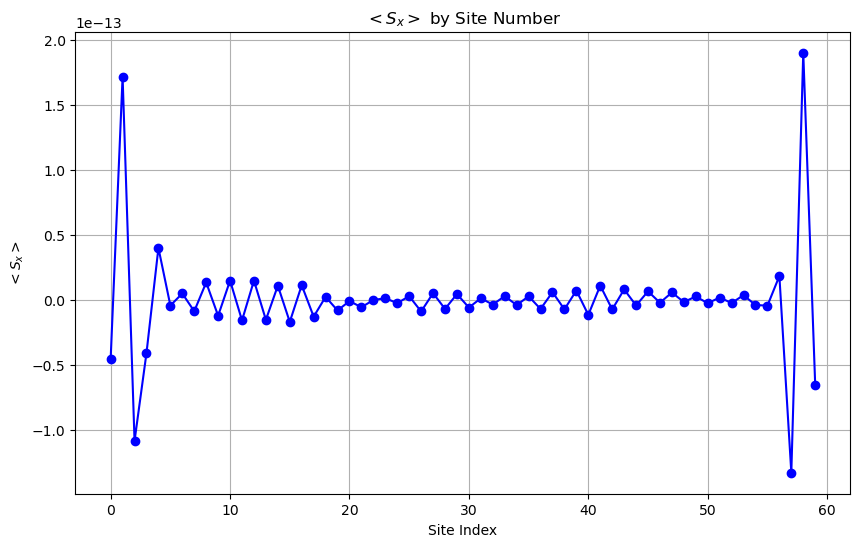

In [12]:
plt.figure(figsize=(10, 6))
plt.plot(np.arange(0,L,1), s_x_averages, 'bo-')
plt.xlabel('Site Index')
plt.ylabel('$<S_x>$')
plt.title('$<S_x>$ by Site Number')
plt.grid(True)
plt.show()

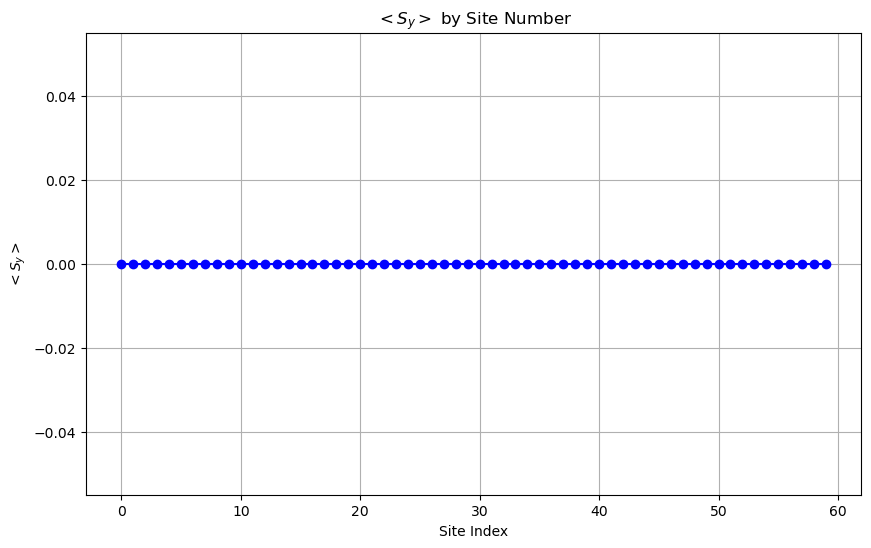

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(np.arange(0,L,1), s_y_averages, 'bo-')
plt.xlabel('Site Index')
plt.ylabel('$<S_y>$')
plt.title('$<S_y>$ by Site Number')
plt.grid(True)
plt.show()

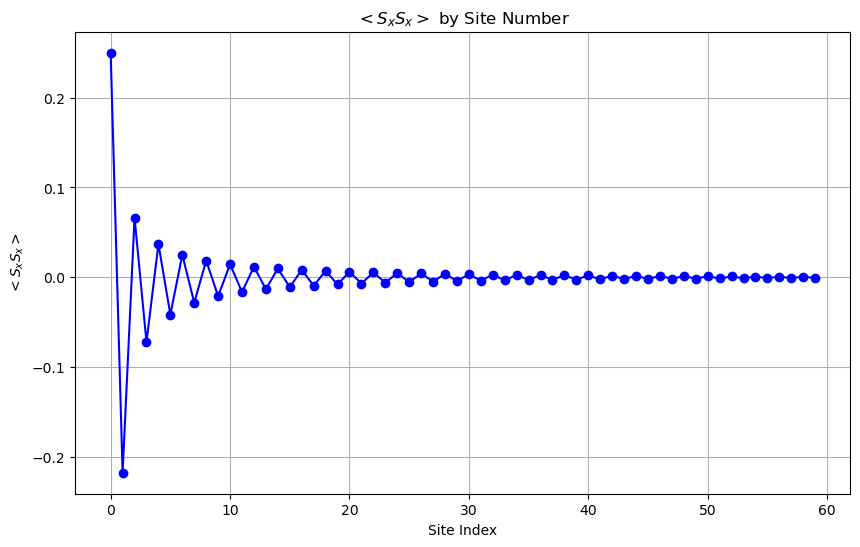

In [14]:
plt.figure(figsize=(10, 6))
plt.plot(np.arange(0,L,1), s_x_s_x_averages, 'bo-')
plt.xlabel('Site Index')
plt.ylabel('$<S_xS_x>$')
plt.title('$<S_xS_x>$ by Site Number')
plt.grid(True)
plt.show()

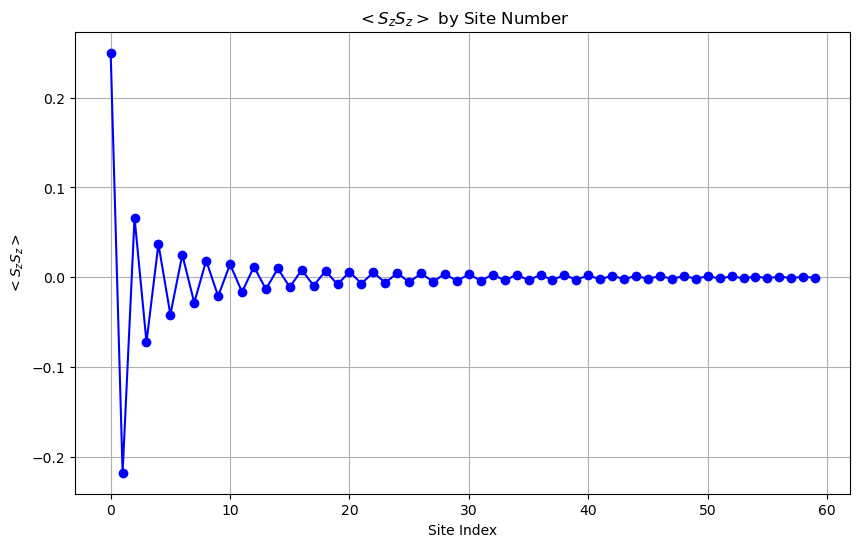

In [15]:
plt.figure(figsize=(10, 6))
plt.plot(np.arange(0,L,1), s_z_s_z_averages, 'bo-')
plt.xlabel('Site Index')
plt.ylabel('$<S_zS_z>$')
plt.title('$<S_zS_z>$ by Site Number')
plt.grid(True)
plt.show()